In [1]:
%load_ext autoreload
%autoreload 2
%run ./initializer

Added the path (/Users/rik/Documents/VU/DMT/DataMiningTechniquesA1) to sys.path


In [2]:
import torch
import torch.nn as nn
import optuna
from sklearn.model_selection import train_test_split
import polars as pl
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

from data_loading import DataPreprocessor
from random_forest_classifier_2a import plot_predicted_vs_actual

/Users/rik/Documents/VU/DMT/DataMiningTechniquesA1/.venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
data_loader = DataPreprocessor()
train_df, pred_df = data_loader.load_and_preprocess_data("1d", 0.5, 1, do_bucketing=False, for_RNN_model=False)

Removed 56 outliers from 1268 observations. Percentage: 4.42%


In [4]:
test_predictions = []
test_actuals = []
final_predictions = []
user_ids = []

# For each user
for id in train_df["id"].unique():
    train_group = train_df[train_df["id"] == id]

    # Keep date column for evaluation
    dates = train_group['date']

    # Then drop id, mood, and date for features
    features = train_group.drop(columns=['id', 'mood', 'date'])
    labels = train_group['mood']
    X_train, X_test, y_train, y_test, dates_train, dates_val = train_test_split(
        features, labels, dates, test_size=0.2, random_state=42
    )

    model = RandomForestRegressor()
    model.fit(X_train, y_train)

    # Predict on the validation set
    y_test_pred = model.predict(X_test)
    test_predictions.extend(y_test_pred)
    test_actuals.extend(y_test)

    # Predict on the prediction set
    pred_group = pred_df[pred_df["id"] == id]
    X_pred = pred_group.drop(columns=["id", "date", "mood"])
    y_pred = model.predict(X_pred)

    final_predictions.append(y_pred[0])
    user_ids.append(id)


Validation Statistics
MAE: 0.5126847389558236
MSE: 0.5362711897590366
R²: -0.04500079769517118


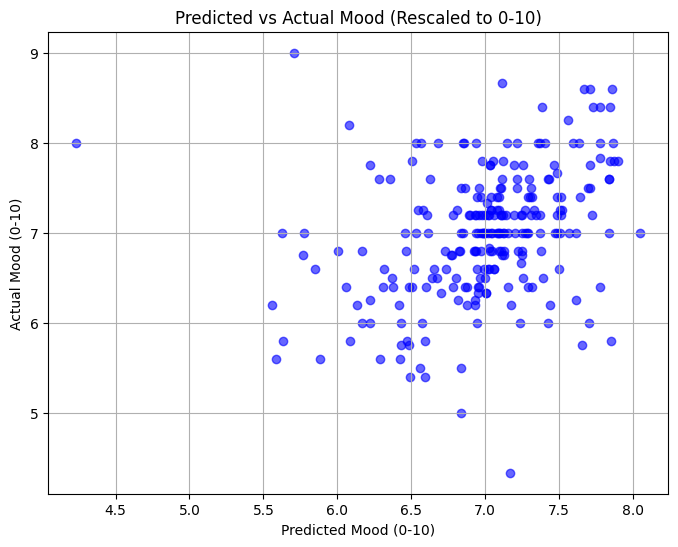

In [5]:
# Evaluate across all users
print("Validation Statistics")
print("MAE:", mean_absolute_error(test_actuals, test_predictions))
print("MSE:", mean_squared_error(test_actuals, test_predictions))
print("R²:", r2_score(test_actuals, test_predictions))
plot_predicted_vs_actual(np.array(test_actuals), np.array(test_predictions))

In [6]:
# Optional: view predictions
results_df = pd.DataFrame({
    "user_id": user_ids,
    "predicted_next_day_mood": final_predictions,
})
print(results_df)

    user_id  predicted_next_day_mood
0   AS14.01                 7.145167
1   AS14.02                 5.857167
2   AS14.03                 7.723333
3   AS14.05                 6.810333
4   AS14.06                 6.973500
5   AS14.07                 3.875500
6   AS14.08                 6.797333
7   AS14.09                 7.011833
8   AS14.12                 6.300000
9   AS14.13                 7.843667
10  AS14.14                 7.086833
11  AS14.15                 6.924500
12  AS14.16                 6.767667
13  AS14.17                 7.231000
14  AS14.19                 6.011667
15  AS14.20                 6.921000
16  AS14.23                 8.221000
17  AS14.24                 7.124167
18  AS14.25                 7.222000
19  AS14.26                 7.111000
20  AS14.27                 7.182500
21  AS14.28                 6.668500
22  AS14.29                 7.825167
23  AS14.30                 7.753500
24  AS14.31                 6.999833
25  AS14.32                 6.978500
2